## Data load

In [1]:
from __future__ import division

In [2]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

dirpath = '../data/'



In [3]:
# Load data
customers = pd.read_csv(dirpath+"olist_customers_dataset.csv")
order_payments = pd.read_csv(dirpath+"olist_order_payments_dataset.csv")
orders = pd.read_csv(dirpath+"olist_orders_dataset.csv")

In [4]:
customer_order = customers.merge(orders, on='customer_id', how='left')

order_payments = order_payments.groupby('order_id').sum().reset_index()[['order_id','payment_value']]
customer_order_payments = customer_order.merge(order_payments, on='order_id', how='left')
customer_order_payments['order_purchase_timestamp'] = pd.to_datetime(customer_order_payments['order_purchase_timestamp'])

cop = customer_order_payments
cop['order_purchase_timestamp'] = pd.to_datetime(cop['order_purchase_timestamp'])

cop = cop[cop['order_status']!='canceled']
cop.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,252.25


In [5]:
customer_order.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

## customer segmentation

The customer segementation is done by the RFM methodolgy: Recency, Frequency and Monetary value

### Recency

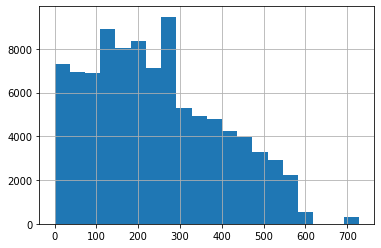

In [6]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
tx_user = pd.DataFrame(cop['customer_unique_id'].unique())
tx_user.columns = ['customer_unique_id']

#get the max purchase date for each customer and create a dataframe with it
tx_max_purchase = cop.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
tx_max_purchase.columns = ['customer_unique_id','MaxPurchaseDate']


#we take our observation point as the max invoice date in our dataset
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days


#merge this dataframe to our new user dataframe
tx_user = pd.merge(tx_user, tx_max_purchase[['customer_unique_id','Recency']], on='customer_unique_id')

tx_user.head()

#plot a recency histogram
tx_user['Recency'].hist(bins=20)



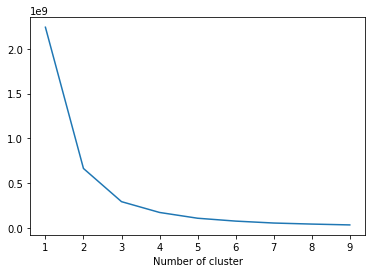

In [7]:
from sklearn.cluster import KMeans

sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [8]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

#df.groupby(['Animal'])

In [9]:
tx_user.groupby(['RecencyCluster']).describe()


Recency                                                     \
                  count        mean        std    min    25%    50%    75%   
RecencyCluster                                                               
0               22684.0  462.458605  69.307755  361.0  404.0  455.0  514.0   
1               36121.0  259.394203  51.290477  176.0  215.0  262.0  296.0   
2               36755.0   91.535573  49.818879    0.0   44.0   92.0  135.0   

                       
                  max  
RecencyCluster         
0               728.0  
1               360.0  
2               175.0

### Frequency

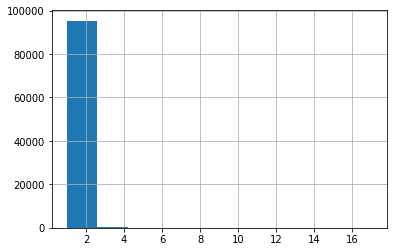

In [10]:
#get order counts for each user and create a dataframe with it
tx_frequency = cop.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
tx_frequency.columns = ['customer_unique_id','Frequency']

#add this data to our main dataframe
tx_user = pd.merge(tx_user, tx_frequency, on='customer_unique_id')

tx_user.head()
tx_user['Frequency'].hist()


In [11]:
#k-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#see details of each cluster
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,92636.0,1.00000,0.00000,1.0,1.0,1.0,1.0,1.0
1,2688.0,2.00000,0.00000,2.0,2.0,2.0,2.0,2.0
2,236.0,3.40678,1.23245,3.0,3.0,3.0,3.0,17.0


In [12]:
cop.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,252.25


### Revenue

In [13]:
#calculate revenue for each customer
#cop['Revenue'] = cop['UnitPrice'] * cop['Quantity']
tx_revenue = cop.groupby('customer_unique_id').payment_value.sum().reset_index()

#merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_revenue, on='customer_unique_id')


In [14]:
tx_user.head()

,customer_unique_id,Recency,RecencyCluster,Frequency,FrequencyCluster,payment_value
0,861eff4711a542e4b93843c6dd7febb0,474,0,1,0,146.87
1,7f3a72e8f988c6e735ba118d54f47458,479,0,1,0,102.03
2,e607ede0e63436308660236f5a52da5e,385,0,1,0,123.00
3,4390ddbb6276a66ff1736a6710205dca,506,0,1,0,94.63
4,2e6a42a9b5cbb0da62988694f18ee295,475,0,1,0,47.59


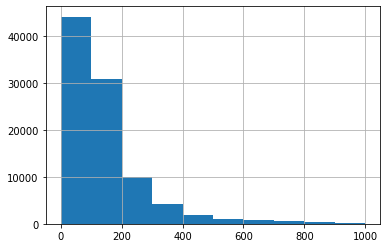

In [15]:
tx_user.payment_value[tx_user['payment_value']<1000].hist()

In [16]:
#apply clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_user[['payment_value']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['payment_value']])


#order the cluster numbers
tx_user = order_cluster('RevenueCluster', 'payment_value',tx_user,True)

#show details of the dataframe
tx_user.groupby('RevenueCluster')['payment_value'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,85065.0,111.490668,65.653494,0.00,58.640,96.710,152.56,303.76
1,9530.0,495.785786,188.589525,303.77,350.135,423.095,600.09,1104.93
2,965.0,1716.916383,815.575642,1107.96,1257.960,1476.800,1936.27,13664.08


In [17]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user.groupby('OverallScore')['Recency','Frequency','payment_value'].mean()

,Recency,Frequency,payment_value
OverallScore,,,
0,462.035941,1.000000,108.317956
1,274.167631,1.011274,133.898305
2,114.191634,1.026002,159.163923
3,116.178693,1.240393,518.583409
4,105.468905,1.661692,1092.245112
5,104.158416,3.415842,849.170297
6,66.500000,3.900000,1745.368000


In [18]:
(2**3)-1

7

In [19]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

# Customer Lifetime Value

we have chosen The lifetime value (LTV) to be 6 months so the period will be from the 01/01/2018 - 01/06/2018
and we take 12 months of data to calculate the RFM and use it for predicting the next 6 months. The 12-month period will stretch from 01/01/2017 - 01/01/2018

In [20]:
from datetime import datetime, timedelta,date

from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [21]:
#create 12m and 6m dataframes
tx_12m = cop[(cop.order_purchase_timestamp < pd.Timestamp(2017,8,1)) & (cop.order_purchase_timestamp >= pd.Timestamp(2017,1,1))].reset_index(drop=True)
tx_6m = cop[(cop.order_purchase_timestamp >= pd.Timestamp(2017,8,1)) & (cop.order_purchase_timestamp < pd.Timestamp(2018,6,1))].reset_index(drop=True)


tx_6m = tx_6m.rename(columns={"payment_value": "Revenue"})
tx_12m = tx_12m.rename(columns={"payment_value": "Revenue"})



In [22]:
#create tx_user for assigning clustering
tx_user = pd.DataFrame(tx_12m['customer_unique_id'].unique())
tx_user.columns = ['customer_unique_id']

#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [23]:
#calculate recency score
tx_max_purchase = tx_12m.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
tx_max_purchase.columns = ['customer_unique_id','MaxPurchaseDate']
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['customer_unique_id','Recency']], on='customer_unique_id')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [24]:
#calcuate frequency score
tx_frequency = tx_12m.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
tx_frequency.columns = ['customer_unique_id','Frequency']
tx_user = pd.merge(tx_user, tx_frequency, on='customer_unique_id')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#calcuate revenue score
tx_revenue = tx_12m.groupby('customer_unique_id').Revenue.sum().reset_index()
tx_user = pd.merge(tx_user, tx_revenue, on='customer_unique_id')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)


#overall scoring
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [25]:
tx_user.head()

,customer_unique_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,861eff4711a542e4b93843c6dd7febb0,76,2,1,0,146.87,0,2,Low-Value
1,7f3a72e8f988c6e735ba118d54f47458,81,2,1,0,102.03,0,2,Low-Value
2,2e6a42a9b5cbb0da62988694f18ee295,77,2,1,0,47.59,0,2,Low-Value
3,fd2d5fdb84e65fa6b54b98b0e2df5645,70,2,1,0,80.57,0,2,Low-Value
4,8728c766c84eeda24b3e54fe6e632051,63,2,1,0,144.26,0,2,Low-Value


### 6 month LTV

Now the 6 month LTV is calculated for each customer

In [26]:
#calculate revenue and create a new dataframe for it
tx_user_6m = tx_6m.groupby('customer_unique_id')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['customer_unique_id','m6_Revenue']



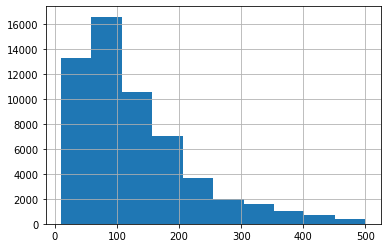

In [27]:
tx_user_6m['m6_Revenue'][tx_user_6m['m6_Revenue']<500].hist()

In [28]:
tx_user_6m['m6_Revenue'].min()

tx_user_6m.head()

,customer_unique_id,m6_Revenue
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f6ccb0745a6a4b88665a16c9f078,43.62
3,0004aac84e0df4da2b147fca70cf8255,196.89
4,0004bd2a26a76fe21f786e4fbd80607f,166.98


Now we will merge our 3 months and 6 months dataframes to see correlations between LTV and the features set we have - (taget fra nettet skal ændres!)

In [29]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='customer_unique_id', how='left')
#tx_merge = tx_merge.fillna(0)

tx_merge.head()
#insert scatter plot her af RFM score vs 6m LTV

,customer_unique_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,861eff4711a542e4b93843c6dd7febb0,76,2,1,0,146.87,0,2,Low-Value,NaN
1,7f3a72e8f988c6e735ba118d54f47458,81,2,1,0,102.03,0,2,Low-Value,NaN
2,2e6a42a9b5cbb0da62988694f18ee295,77,2,1,0,47.59,0,2,Low-Value,NaN
3,fd2d5fdb84e65fa6b54b98b0e2df5645,70,2,1,0,80.57,0,2,Low-Value,NaN
4,8728c766c84eeda24b3e54fe6e632051,63,2,1,0,144.26,0,2,Low-Value,NaN


In [30]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]


#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,304.0,91.741579,42.476952,14.08,56.530,86.62,125.895,175.87
1,89.0,262.754944,63.948310,178.27,204.340,258.41,313.530,417.74
2,19.0,587.331053,112.030922,453.80,498.695,556.86,677.325,830.64


In [1]:
tx_cluster.head()

NameError: name 'tx_cluster' is not defined

In [40]:
#convert categorical columns to numerical

tx_class = pd.get_dummies(tx_cluster, columns=['Segment'])


In [41]:
tx_class.head()


,customer_unique_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,18e3d276253780b44b5b7bf83f6785ec,89,2,1,0,96.88,0,2,71.97,0,0,1,0
1,49d1599dd80dedc213037342bbe43fd7,59,2,1,0,40.77,0,2,77.80,0,0,1,0
2,54c7b4f48fb9e911bf328bf9884ca61d,49,2,1,0,92.37,0,2,92.37,0,0,1,0
3,2b952792a20f6076f6e7a9c6a27ade02,56,2,1,0,47.54,0,2,82.60,0,0,1,0
4,cb4253d36367737b6baa4f8ca58fac62,47,2,1,0,83.14,0,2,59.66,0,0,1,0


In [88]:
#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.895997
RevenueCluster        0.193827
Segment_High-Value    0.190668
Revenue               0.182048
FrequencyCluster      0.132011
Frequency             0.131075
OverallScore          0.073688
Recency               0.010619
Segment_Low-Value     0.010429
RecencyCluster       -0.027921
Segment_Mid-Value    -0.075837
Name: LTVCluster, dtype: float64

In [90]:
#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['customer_unique_id','LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit(X)



from sklearn.preprocessing import StandardScaler
#
scaler = StandardScaler()
cols_to_use = X_cols + [y_col]
data[cols_to_use] = scaler.fit_transform(data[cols_to_use])

In [91]:
#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

TypeError: Singleton array array(MinMaxScaler(copy=True, feature_range=(0, 1)), dtype=object) cannot be considered a valid collection.

### Logistic regression 

creating a baseline classifier to later compare with a more advanced model

In [81]:
from sklearn.linear_model import LogisticRegression

In [82]:
X_train.head()

,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
82,124,1,1,0,56.04,0,1,0,1,0
223,1,3,1,0,53.49,0,3,0,0,1
98,138,1,1,0,189.68,0,1,0,1,0
17,54,2,1,0,105.89,0,2,0,1,0
145,185,0,1,0,125.09,0,0,0,1,0


In [83]:
X_train.shape

(391, 10)

In [63]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')

clf.fit(X_train.il.values, y_train.iloc[:,1:].values)
.

IndexingError: Too many indexers